# Retrieval Augmented Diffusion Model for Time-Series Forecasting

Authors: </br>
Valerio Baldi 1940729 </br>
Saverio Dieni 1946039 </br>

Selected paper: <br/>
[**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)

# References

Paper: [**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)<br/>
Dataset: [**HouseTS Dataset from Kaggle**](https://www.kaggle.com/datasets/shengkunwang/housets-dataset)

# Project aim and paper description

The project aims to implement a generative model for time-series forecasting, applying it to a house-price and socioeconomic dataset. As demostrated in the paper, the model improves the general diffusion model framework by adding embedding-based retrieval mechanism that retrieves series sharing similar patterns from a reference database. It improves the model generation by exploiting the references, to overcome the lack of guidance in the forecasting process, leading to more accurate and context-aware forecasts.<br/>
In particular the framework proposed in the paper suggested to use a pre-trained encoder for time-series. The encoder compresses time-series, simplifying the task of finding series with similar patterns. It is also produced an index of the embeddings for a fast retrieval of the reference. </br> 

# Theoretical background and key concepts

Retrieval-Augmented Time-Series Diffusion (RATD) is based on the theory of diffusion probabilistic models, which are generative models that learn to reverse a Markovian forward noising process. These models are designed to learn the reverse of a forward noising process, where an original sample x0​ is progressively corrupted into xT​. <br/>

The model takes as input a time-series, where the tail of the series is completely filled with noise, and the model is able to recostruct the original signal, exploiting the context retrieved by the head of the series, the references and the side information.</br>

As previously described, the references were found by looking at the k-nearest neighbours in a lower dimensional space, with respect to the head of the series, and we take as references the tails of those neighbours. <br/>

The side information is obtained by concatenating the temporal embeddings with the feature embeddings, where the temporal embeddings are sinusoidal positional embeddings, while the feature embeddings are learnable positional embeddings.  

These embeddings are concatenated and fed into attention modules based on a Transformer architecture.

The model adopts a lightweight attention mechanism inspired by CSDI, consisting of alternating temporal and feature Transformer layers. By using linear attention, RATD is able to handle long sequences and large datasets more efficiently.

# Reproducibility

We both launched this notebook on our machines and on Kaggle notebooks. Before starting the process is required to import all the modules defined in the import section. It is also necessary to have available the auto-encoder for housets defined in the notebook "autoencoder_for_housets.ipynb". You can direclty find the pre-trained auto-encoder model in the folder "models", with the name "encoder.pth".

# Import

In [94]:
pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: faiss-cpu in c:\users\saver\appdata\local\programs\python\python312\lib\site-packages (1.9.0.post1)




[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
pip install linear-attention-transformer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
import torch
import torch.nn as nn
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from linear_attention_transformer import LinearAttentionTransformer
import math 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import faiss
from IPython.display import display
import random
from sklearn.utils import shuffle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # conflict between faiss and pytorch libraries 

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data extraction and preprocessing

In this section we extract the time series from the CSV file. <br/>
The original dataset contains entries of the form <date, median_sale_price, median_list_price, median_ppsf, median_list_ppsf, homes_sold, pending_sales, new_listings, inventory, median_dom, avg_sale_to_list, sold_above_list, off_market_in_two_weeks, city, zipcode, year, bank, bus, hospital, mall, park, restaurant, school, station, supermarket, Total Population, Median Age, Per Capita Income, Total Families Below Poverty, Total Housing Units, Median Rent,Median Home Value, Total Labor Force, Unemployed Population, Total School Age Population, Total School Enrollment, Median Commute Time, price, city_full>, where the combination of <zipcode, year> is a key for the dataset. 
The HouseTS dataset contains also satellite images, grouped by zipocode in different folders. For this reason we decided to keep only the entries relative to zones linked to images. 
The zipcode is a representative value for each zone of Washington.</br>
We extract time series of length of 24 steps (24 months), where our final aim is to predict the last 12 timesteps given the previous 12s. </br>
As preprocessing we dropped non relevant features in this simplified scenario, and we also extracted metadata: zipcode, timestamp, year.  

In [98]:
window_length = 24 # 12 known timesteps, the last 12 timestemps to be predicted
step_size = 1

In [99]:
csv_file = "HouseTS_with_images.csv"
df = pd.read_csv(csv_file)

df = df.drop(columns=['city', 'city_full'])

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['zipcode', 'date']).reset_index(drop=True)

feature_columns = [col for col in df.columns if col not in ['date', 'zipcode', 'year']]
feature_index_mapping = {i: col for i, col in enumerate(feature_columns)}

print("Feature index mapping:")
print(feature_index_mapping)

all_windows = []
all_meta = []

def extract_windows(df_sub, window_len, step):
    windows = []
    for i in range(0, len(df_sub) - window_len + 1, step):
        window = df_sub.iloc[i:i+window_len].drop(columns=['date', 'zipcode', 'year']).values
        windows.append(window)
    return np.array(windows)

# Group by zipcode
for zipcode, group in df.groupby('zipcode'):
    group = group.reset_index(drop=True)
    if len(group) < window_length:
        continue

    windows = extract_windows(group, window_length, step_size)
    all_windows.append(windows)

    # Save metadata
    window_meta = [(zipcode, group.loc[i, 'date'], group.loc[i, 'year']) for i in range(len(group) - window_length + 1)]
    all_meta.extend(window_meta)

# Concatenate all the windows
X = np.vstack(all_windows)  # shape: (num_samples, window_length, num_features)

print("Shape of X:", X.shape)
print("Number of metadata entries:", len(all_meta))
print("Metadata example:", all_meta[0])

Feature index mapping:
{0: 'median_sale_price', 1: 'median_list_price', 2: 'median_ppsf', 3: 'median_list_ppsf', 4: 'homes_sold', 5: 'pending_sales', 6: 'new_listings', 7: 'inventory', 8: 'median_dom', 9: 'avg_sale_to_list', 10: 'sold_above_list', 11: 'off_market_in_two_weeks', 12: 'bank', 13: 'bus', 14: 'hospital', 15: 'mall', 16: 'park', 17: 'restaurant', 18: 'school', 19: 'station', 20: 'supermarket', 21: 'Total Population', 22: 'Median Age', 23: 'Per Capita Income', 24: 'Total Families Below Poverty', 25: 'Total Housing Units', 26: 'Median Rent', 27: 'Median Home Value', 28: 'Total Labor Force', 29: 'Unemployed Population', 30: 'Total School Age Population', 31: 'Total School Enrollment', 32: 'Median Commute Time', 33: 'price'}
Shape of X: (36652, 24, 34)
Number of metadata entries: 36652
Metadata example: (20001, Timestamp('2012-03-31 00:00:00'), 2012)


We shuffled the dataset fixing the seed for replication purposes, then we splitted the dtaset for the training, evaluation and testing, respectively with a proportion 70%, 10% 20%. We normalized the datasets, according to the training dataset. Finally we created the DataLoaders, with a batch size of 32. 

In [100]:
X, all_meta = shuffle(X, all_meta, random_state=626)

train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

meta_train = all_meta[:train_size]
meta_val = all_meta[train_size:train_size + val_size]
meta_test = all_meta[train_size + val_size:]

In [101]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, meta, seq_len=None):
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.meta = meta  # [(zipcode, date, year)]
        self.seq_len = seq_len or X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (seq_len, num_features)

        zipcode, date, year = self.meta[idx]

        # Convert date to UNIX timestamp and repeat
        timestamp = int(pd.Timestamp(date).timestamp())
        timestamps = torch.full((self.seq_len,), timestamp, dtype=torch.long)

        # Repeat year
        year_tensor = torch.full((self.seq_len,), year, dtype=torch.long)

        return x, timestamps, year_tensor

In [102]:
# Compute the statistics of the train dataset and normalize with respect to it 
mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
std = X_train.std(axis=(0, 1), keepdims=True)

X_train_norm = (X_train - mean) / std
X_val_norm = (X_val - mean) / std
X_test_norm = (X_test - mean) / std

train_dataset = TimeSeriesDataset(X_train_norm, meta_train)
val_dataset = TimeSeriesDataset(X_val_norm, meta_val)
test_dataset = TimeSeriesDataset(X_test_norm, meta_test)

X_train_tensor =  train_dataset.X

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Retrieval Database

We reloaded the pre-trained encoder-decoder to embed the train dataset and build an efficient retrieval database for top k nearest neighbours search. 

In [103]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation  # full causal
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)

        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)

        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2,
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        if out.shape != res.shape:
            # Align time dimension by cropping the residual (this might be necessary in some edge cases)
            min_len = min(out.size(-1), res.size(-1))
            out = out[..., :min_len]
            res = res[..., :min_len]
        return self.relu(out + res)


In [104]:
# Encoder
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_dim if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))
        self.tcn = nn.Sequential(*layers)

        # Projection from [B, C, T] to [B, emb_dim]
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.project = nn.Linear(num_channels[-1], emb_dim)

    def forward(self, x):
        # x: [B, T, D] → [B, D, T]
        x = x.permute(0, 2, 1)
        x = self.tcn(x)  # [B, C, T]
        x = self.pool(x).squeeze(-1)  # [B, C]
        x = self.project(x)  # [B, emb_dim]
        return x

# Decoder
class TCNDecoder(nn.Module):
    def __init__(self, emb_dim, output_dim, seq_len, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.output_dim = output_dim

        # Project embedding back to a sequence shape: [B, C, T]
        self.expand = nn.Linear(emb_dim, num_channels[0] * seq_len)

        layers = []
        for i in range(len(num_channels) - 1):
            in_ch = num_channels[i]
            out_ch = num_channels[i + 1]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))

        self.tcn = nn.Sequential(*layers)
        self.out_proj = nn.Conv1d(num_channels[-1], output_dim, kernel_size=1)

    def forward(self, x):
        # x: [B, emb_dim] → [B, C0, T]
        x = self.expand(x)  # [B, C0 * T]
        x = x.view(x.size(0), -1, self.seq_len)  # [B, C0, T]
        x = self.tcn(x)  # [B, Cn, T]
        x = self.out_proj(x)  # [B, D, T]
        return x.permute(0, 2, 1)  # [B, T, D]

In [105]:
class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.encoder = TCNEncoder(input_dim, emb_dim, channels, kernel_size, dropout)
        self.decoder = TCNDecoder(emb_dim, input_dim, seq_len, channels[::-1], kernel_size, dropout)

    def forward(self, x, only_encoder = False):
        # x: [B, T, D]
        z = self.encoder(x)       # [B, emb_dim]
        if only_encoder:
            return z
        x_recon = self.decoder(z) # [B, T, D]
        return x_recon


In [106]:
encoder_path = "models/encoder.pth"
T, D = 12, 34
emb_dim = 64
channels = [32, 64, 128]

encoder_loaded = TCNAutoencoder(input_dim=D, emb_dim=emb_dim, seq_len=T, channels=channels)

encoder_loaded.load_state_dict(torch.load(encoder_path, map_location=device))

encoder_loaded.to(device)

encoder_loaded.eval()

print("Models reloaded successfully.")

Models reloaded successfully.


C:\Users\saver\AppData\Local\Temp\ipykernel_23488\3833310308.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_loaded.load_state_dict(torch.load(encoder_path, map_

As indicated in the paper, we build the retrieval database starting from the train dataset. In particular for each time series in the train dataset, the retrieval database DR_emb contains a couple (embedding, target), where embedding is obtained as the result of the encoder on the head of the series, in our case we consider the first 12 timesteps, and the target is simply the tail of the series, in our case of length 12. </br>
We want to use the retrieval database Dr_emb to find the top k nearest neighbours, to use as a reference for the prediction model. At this purpose we indexed the database using the FAISS implementation, which is very effective for large datasets, so to search fast even increasing the number of samples.  

In [107]:
@torch.no_grad()
def build_retrieval_database(dataset, encoder, n, h, device):
    """
    Build the retrieval database DR_emb as a list of tuples (embedding, target).
    
    Args:
        dataset: tensor (N, n+h, D)
        encoder: pre-trained model
        n: head of the sequence
        h: len of the target

    Returns:
        List of tuples: [(embedding_i, target_i)]
    """
    encoder.eval()
    dataset = dataset.to(device)
    emb_list = []
    for i in range(dataset.shape[0]):
        x = dataset[i:i+1, :n, :]        # (1, n, D)
        y = dataset[i, n:n+h, :].clone() # (h, D)
        emb = encoder(x, only_encoder = True)                 # (1, embedding_dim)
        emb_list.append((emb.squeeze(0).cpu(), y.cpu()))
    return emb_list


In [108]:
def build_faiss_index(retrieval_db, use_gpu=False):
    """
    Build a FAISS index starting from the retrieval_db.

    Args:
        retrieval_db: list of (embedding, target)

    Returns:
        index: FAISS index
        targets: tensor (N, h, D)
    """
    # Extract embeddings e targets
    embeddings = torch.stack([emb for (emb, _) in retrieval_db])  # (N, embdim)
    targets = torch.stack([tgt for (_, tgt) in retrieval_db])      # (N, h, D)

    emb_dim = embeddings.shape[1]
    embeddings_np = embeddings.numpy().astype('float32')

    # Build the index (FlatL2 = exact KNN, IVFFlat = approximated KNN)
    index = faiss.IndexFlatL2(emb_dim) 
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(embeddings_np)  # index all the embeddings
    return index, targets

In [109]:
def retrieve_knn(xH, encoder, faiss_index, targets_db, k, device):
    """
    KNN using the FAISS index.

    Args:
        xH: tensor (B, n, D)
        encoder: pre-trained encoder
        faiss_index: index FAISS
        targets_db: tensor (N, h, D)
        k: number of neighbours 

    Returns:
        xR: tensor (B, k, h, D)
    """
    encoder.eval()
    with torch.no_grad():
        vH = encoder(xH.to(device), only_encoder = True)  # (B, emb_dim)

    vHnp = vH.cpu().numpy().astype('float32')
    _, indices = faiss_index.search(vHnp, k)  # (B, k)

    indices_torch = torch.from_numpy(indices)  # (B, k)
    xR = targets_db[indices_torch]  # (B, k, h, D)
    return xR


In [110]:
for p in encoder_loaded.parameters():
    p.requires_grad = False

retrieval_db = build_retrieval_database(X_train_tensor, encoder_loaded, n=12, h=12, device=device)
faiss_index, xr_target = build_faiss_index(retrieval_db)

# Model

In this section we developed the RATD model according to the descriptions and the graphical representations reported in the paper.</br> </br>
<img src="ratd_architecture.png"> </br></br>
We started from the implementation of the module regarding the side information (time embeddings + feature embeddings) and the diffusion timestep embeddings. 
Then we implemented the other blocks lik the RMA (Reference Modulated Attention) module, the Time and the Feature Tranformers, starting from the implementation provived by LinearAttentionTransformer, and finally the GAU (Gated Activation Unit) module. </br>
We composed all together these blocks in the module RATDLayer, that includes all the computations done in a single step of the model. Lastly we implemented the complete RATD model, by stacking the layers and applying additonal computations adding the noise to the input, initializing the side information and the diffiusion timestep embedding, and finally processing the results of each layer.    

In [1]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            dilation=dilation
        )

    def forward(self, x):
        # x shape: (batch, channels, seq_len)
        pad = (self.kernel_size - 1) * self.dilation
        x = F.pad(x, (pad, 0))  # pad left only
        return self.conv(x)

In [ ]:
class SideInformation(nn.Module):
    def __init__(self, num_features: int, time_dim: int = 32, feat_dim: int = 16, base: int = 10000):
        """
        time_dim: dimension of the sinusoidal time embeddings
        feat_dim: dimension of the feature embeddings
        """
        super().__init__()
        self.num_features = num_features
        self.time_dim = time_dim
        self.feat_dim = feat_dim
        self.total_dim = time_dim + feat_dim  # 144, as in the paper 
        self.base = base

        # Learnable feature embedding: (num_features, feat_dim)
        self.feature_embedding = nn.Parameter(torch.randn(num_features, feat_dim))

    def forward(self, timestamps: torch.Tensor) -> torch.Tensor:
        """
        timestamps: (batch, seq_len)
        Returns:
            side_info Is: (batch, total_dim, seq_len, num_features)
        """
        batch_size, seq_len = timestamps.shape
        device = timestamps.device

        # Temporal sinusoidal embedding 
        positions = timestamps.float().unsqueeze(-1)  # (batch, seq_len, 1)
        div_term = torch.exp(
            torch.arange(0, self.time_dim, 2, device=device) * -(np.log(self.base) / self.time_dim)
        )  # (time_dim/2,)
        sin_embed = torch.sin(positions * div_term)  # (batch, seq_len, time_dim/2)
        cos_embed = torch.cos(positions * div_term)  # (batch, seq_len, time_dim/2)
        time_emb = torch.cat([sin_embed, cos_embed], dim=-1)  # (batch, seq_len, time_dim)

        # Feature embedding learnable 
        feat_emb = self.feature_embedding.unsqueeze(0).unsqueeze(0)  # (1, 1, num_features, feat_dim)
        feat_emb = feat_emb.expand(batch_size, seq_len, -1, -1)      # (batch, seq_len, num_features, feat_dim)

        # Expand time embedding to match num_features 
        time_emb = time_emb.unsqueeze(2).expand(-1, -1, self.num_features, -1)  # (batch, seq_len, num_features, time_dim)

        # Concatenate 
        side_info = torch.cat([time_emb, feat_emb], dim=-1)  # (batch, seq_len, num_features, total_dim)

        # Permute: (batch, total_dim, seq_len, num_features)
        side_info = side_info.permute(0, 3, 1, 2)

        return side_info  # Is


The RMA module was built following the structure provided in the paper, as shown in the image below:</br></br>
<img src="RMA_module.png"></br></br>
The module use attention on the references and on the side information to guide the generation process.

In [ ]:
class RMA(nn.Module): 
    def __init__(self, input_dim, inner_dim=16):
        super().__init__()
        self.q_proj = nn.Linear(input_dim, inner_dim)
        self.k_proj = nn.Linear(2 * input_dim, inner_dim)
        self.v_proj = nn.Linear(3 * input_dim, inner_dim)
        self.out = nn.Linear(inner_dim, input_dim)

    def forward(self, x, side_info, xr=None, causal=False):
        """
        x:         (B, C, T, D)
        xr:        Optional. (B, C, T, D) or None
        side_info: (B, C, T, D)
        Returns:
        Z: (B, C, T, D)
        """
        B, C, T, D = x.shape

        # If xr is None, use zero tensor
        if xr is None:
            xr = torch.zeros_like(x)

        if causal:
            # Causal mask: only x_{<t}, exclude x_t itself
            mask = torch.tril(torch.ones(T, T, device=x.device), diagonal=-1)  # (T, T)
        
            # Reshape for matmul: (B, C, D, T)
            x = x.permute(0, 1, 3, 2)  # (B, C, D, T)
        
            # Apply mask: (B, C, D, T) x (T, T) -> (B, C, D, T)
            x = torch.matmul(x, mask)  # each t gets sum of x_{<t}
        
            # Reshape back to (B, C, T, D)
            x = x.permute(0, 1, 3, 2)


        # 1. Concat references and side_info: (B, C, T, D)
        k_input = torch.cat([xr, side_info], dim=-1)
        v_input = torch.cat([x, k_input], dim=-1)

        # 2. Linear projections
        Q = self.q_proj(x)  # (B, C, T, D_inner)
        K_proj = self.k_proj(k_input)  # (B, C, T, D_inner)
        V_proj = self.v_proj(v_input)  # (B, C, T, D_inner)

        # 3. Rearrange K and V for matmul
        # shape: (B, T, C, D_inner)
        K_flat = K_proj.permute(0, 2, 1, 3)
        V_flat = V_proj.permute(0, 2, 1, 3).reshape(B*T, C, V_proj.shape[-1])

        # 4. Attention computation
        # softmax over C dimension (i.e., across references + side info)
        A = torch.softmax(K_flat, dim=2)  # (B, T, C, D_inner)

        # compute A^T V: (B*T, D_inner, C) X (B*T, C, D_inner)
        A_T = A.permute(0, 1, 3, 2).reshape(B*T, A.shape[-1], C)  # (B*T, D_inner, C) 
        attn_matrix = torch.bmm(A_T, V_flat)  # (B*T, D_inner, D_inner)

        # 5. Q × A: (B*C, T, D_inner) x (B*T, D_inner, D_inner)
        Q = Q.permute(0, 2, 1, 3).reshape(B*T, C, Q.shape[-1])  # (B*T, C, D_inner)
        Z = torch.bmm(Q, attn_matrix)  # (B*T, C, D_inner)

        Z = self.out(Z) # (B*T, C, D)

        # Rearrange back: (B, C, T, D)
        Z = Z.reshape(B, T, C, Z.shape[-1]).permute(0, 2, 1, 3)

        return Z, attn_matrix


In [ ]:
# test modules

B, T, D = 32, 12, 34
C = 16
K = 3
side_module = SideInformation(num_features=D)
timestamps = torch.randint(18000, 20000, (B, T))
side_info = side_module(timestamps)  # (B, 144, T, D)

x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, C, T, D)

rma = RMA(input_dim=D)

out = rma(x, side_info, xr, causal=True)[0]

print("Output shape:", out.shape)  # (B, T, inner_dim)

Output shape: torch.Size([32, 16, 12, 34])


In [ ]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=2):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 256,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 2, 1, 3).reshape(B * T, C, D) # (B * T, C, D)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, T, C, D).permute(0, 2, 1, 3) # (B, C, T, D)
        return x


In [ ]:
class FeatureTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=2):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 256,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 3, 1, 2).reshape(B * D, C, T) # (B * D, C, T)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, D, C, T).permute(0, 2, 3, 1) # (B, C, T, D)
        return x


In [ ]:
class LearnableDiffusionTimestepEmbedding(nn.Module):
    def __init__(self, num_timesteps: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_timesteps, embedding_dim)

    def forward(self, timesteps: torch.Tensor):
        """
        timesteps: (batch_size,) tensors of integers ∈ [0, num_timesteps)
        """
        return self.embedding(timesteps)  # (batch_size, embedding_dim)


In [ ]:
# Gated Activation Unit
class GAU(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.projection = CausalConv1d(channels, 2 * channels, kernel_size=3)

    def forward(self, x):
        """"
        input: x (B, C, D)
        output: x (B, C, D)
        """
        # Doubling the number of channels 
        x = self.projection(x)  # (B, 2*C, D)
        # Split x in 2 chunchs
        gate, filter = torch.chunk(x, 2, dim=1)  # each of them with shape (B, C, D)
        # Gate the result
        x = torch.sigmoid(gate) * torch.tanh(filter)  # (B, C, D)
        return x

In [ ]:
class RATDLayer(nn.Module):
    def __init__(self, input_dim, channels, seq_len, context_dim, side_dim, emb_dim):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.rma = RMA(input_dim=input_dim)
        self.time_feature_conv = CausalConv1d(side_dim * seq_len, channels * seq_len, kernel_size=3)
        self.diff_timestep_emb_conv = CausalConv1d(emb_dim, channels * seq_len, kernel_size=3)
        self.ln = nn.LayerNorm((channels, seq_len, input_dim))
        self.temporal_transformer = TemporalTransformer(d_model=channels)
        self.feature_transformer = FeatureTransformer(d_model=channels)
        self.gau = GAU(channels * seq_len)
        self.conv_out1 = CausalConv1d(channels * seq_len, channels * seq_len, kernel_size=3)
        self.conv_out2 = CausalConv1d(channels * seq_len, channels * seq_len, kernel_size=3)

    def forward(self, x, side_info, diff_emb, xr=None):
        """
        x: (B, C, T, D) 
        xr: (B, C, T, D)
        side_info: (B, 144, T, D)
        diff_emb: (B, emb_dim, 1)
        """
        B, C, T, D = x.shape
        K = self.context_dim
        side_dim = self.side_dim

        res_x = x.reshape(B, C*T, D) 
        diff_emb = self.diff_timestep_emb_conv(diff_emb) # (B, C*T, 1)
        x = x.reshape(B, C*T, D) + diff_emb
        x = x.reshape(B, C, T, D) # (B, C, T, D)
        side_info = side_info.reshape(B, side_dim*T, D) # (B, side_dim*T, D)
        side_info = self.time_feature_conv(side_info) # (B, C*T, D)
        side_info = side_info.reshape(B, C, T, D)
        res_side_info = side_info
        x = self.rma(x, side_info, xr, causal = True)[0] # (B, C, T, D)
        x = self.ln(x)
        x = self.temporal_transformer(x) # (B, C, T, D)
        x = self.ln(x)
        x = self.feature_transformer(x) # (B, C, T, D)
        x = x + res_side_info
        x = self.ln(x)
        x = x.reshape(B, C*T, D)
        x = self.gau(x)
        y = x 
        x = self.conv_out1(x) + res_x # (B, C*T, D)
        x = x.reshape(B, C, T, D)
        x = self.ln(x)
        y = self.conv_out2(y) # (B, C*T, D)

        return x, y

In [ ]:
# test
B, T, D = 32, 12, 34
C = 16
K = 3
emb_dim = 64
x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, 48, T, D)
lfte = LearnableDiffusionTimestepEmbedding(num_timesteps=T, embedding_dim=emb_dim)

timesteps = torch.randint(0, T, (B,), dtype=torch.long)
emb = lfte(timesteps).unsqueeze(-1)  # (B, emb_dim, 1)
print(emb.shape)
ratdlayer = RATDLayer(D, C, T, K, 48, emb_dim)
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
x, y = ratdlayer(x, side_info, emb, xr)

# print(prof.key_averages().table(sort_by="cuda_time_total"))
    
print("Output x.shape:", x.shape)
print("Output y.shape:", y.shape)

torch.Size([32, 64, 1])
Output x.shape: torch.Size([32, 16, 12, 34])
Output y.shape: torch.Size([32, 192, 34])


In [ ]:
print(f"RATDLayer parameters: {count_parameters(ratdlayer):,}")

RATDLayer parameters: 835,570


In [ ]:
class RATD(nn.Module):
    def __init__(self, input_dim, channels, context_dim, side_dim, 
                emb_dim, original_len, seq_len, n_layers=5):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.original_len = original_len
        self.l = seq_len - original_len
        self.n_layers = n_layers
        self.a = nn.Parameter(torch.ones(n_layers + 1, channels), requires_grad=True)
        self.t_len = 20

        mask_0 = torch.zeros((seq_len//2, input_dim))
        mask_1 = torch.ones((seq_len//2, input_dim))
        self.mask = torch.cat([mask_0, mask_1], dim = 0)
        self.cond_mask = torch.cat([mask_1, mask_0], dim = 0)

        self.input_dim = input_dim
        self.ldte = LearnableDiffusionTimestepEmbedding(num_timesteps=self.t_len, embedding_dim=emb_dim)
        self.side_module = SideInformation(num_features=input_dim)

        self.layers = nn.ModuleList(
            [ RATDLayer(input_dim, channels, seq_len, context_dim, side_dim, emb_dim) for _ in range(n_layers) ]
        )
        self.input_conv = CausalConv1d(seq_len, channels * seq_len, kernel_size=3)
        self.gelu = nn.GELU()
        self.ref_conv = CausalConv1d(context_dim * seq_len, channels * seq_len, kernel_size=3)
        self.conv_out1 = CausalConv1d(channels * seq_len, channels * seq_len, kernel_size=3)
        self.conv_out2 = CausalConv1d(channels * seq_len, seq_len, kernel_size=3)

        # Diffusion parameters
        beta_start = 0.1
        beta_end = 0.9
        self.beta = np.linspace(beta_start, beta_end, self.t_len)
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.register_buffer("alpha_torch", torch.tensor(self.alpha).float().unsqueeze(1).unsqueeze(1))

    def forward(self, x, timestamps, xr=None, t = None):
        """
        x: (B, T, D) 
        xr: (B, K, l, D) or None
        out : (B, T, D)
        """
        B, _, D = x.shape
        C = self.channels
        K = self.context_dim
        T = self.seq_len
        original_T = T - self.l

        # Build the side_info and the diff_emb
        if t is None:
            t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        diff_emb = self.ldte(t.to(self.ldte.embedding.weight.device))
        diff_emb = diff_emb.unsqueeze(-1)  # (B, emb_dim, 1)
         
        side_info = self.side_module(timestamps)

        if xr is not None:
            # Reconstruct xr to make it of the same length of x 
            x_truncated = x[:, 0:original_T, :] # (B, original_len, D)
            x_rep = x_truncated.unsqueeze(1).repeat(1, K, 1, 1).to(xr.device)  # (B, K, original_len, D)
            xr = torch.cat([x_rep, xr], dim=2)  # (B, K, T, D)

        # Save the input for residual connections
        res_x = x[:, :original_T, :].unsqueeze(1).repeat(1, C, 1, 1)  # (B, C, T-l, D)

        x = self.gelu(self.input_conv(x)) # (B, C*T, D)
        x = x.reshape(B, C, T, D)

        if xr is not None:
            xr = xr.reshape(B, K*T, D) # (B, K*T, D)
            xr = self.ref_conv(xr) # (B, C*T, D)
            xr = xr.reshape(B, C, T, D)

        b_stack = torch.empty((self.n_layers, B, C * T, D), device=x.device)
        for i, layer in enumerate(self.layers):
            x, b = layer(x, side_info, diff_emb, xr)
            # Convex interpolation between the residual x and the output of the layer
            a_vec = torch.clamp(self.a[i], 0.0, 1.0)  # (C,)
            b_vec = 1.0 - a_vec                       # (C,)
            a_weight = a_vec.view(1, -1, 1, 1)
            b_weight = b_vec.view(1, -1, 1, 1)
            aux = a_weight * x[:, :, :original_T, :] + b_weight * res_x
            x = torch.cat([aux, x[:, :, original_T:, :]], dim=2)
            # Store intermediate output of the layer 
            b_stack[i] = b

        # Combine the intermediate outputs and rescale
        out = torch.sum(b_stack, dim=0) / math.sqrt(self.n_layers) # (B, C*T, D)
        
        out = self.gelu(self.conv_out1(out)) # (B, C*T, D)

        # Convex interpolation between the residual x and out
        a_vec = torch.clamp(self.a[self.n_layers], 0.0, 1.0)  # (C,)
        b_vec = 1.0 - a_vec                       # (C,)
        a_weight = a_vec.view(1, -1, 1, 1)
        b_weight = b_vec.view(1, -1, 1, 1)
        out = out.reshape(B, C, T, D)
        aux = a_weight * out[:, :, :original_T, :] + b_weight * res_x
        out = torch.cat([aux, out[:, :, original_T:, :]], dim=2)
        out = out.reshape(B, C*T, D)

        out = self.conv_out2(out)

        # Copy the head (original_T) of the time series
        if not self.training:
            out = torch.cat([res_x[:, 0, :, :].reshape(B, original_T, D), out[:, original_T:, :]], dim=1)
        
        return out

    def calc_loss(self, x0, timestamps, xr=None, t=None):

        original_T = self.seq_len - self.l
        
        if t is None:
            # sample t uniformly at random
            t = torch.randint(0, self.t_len, (x0.shape[0],), device=x0.device)

        alpha_t = self.alpha_torch[t]

        noise = torch.randn_like(x0)
        xt = x0.detach().clone()
        # Build xt from x0, adding random nois on the tail of the series according to alpha_t
        xt[:, original_T: , :] = (alpha_t ** 0.5) * x0[:, original_T: , :] + ((1 - alpha_t) ** 0.5) * noise[:, original_T: , :]

        # Reconstruct x0 from xt
        pred = self.forward(xt, timestamps, xr, t)
        # Compute the residual
        residual = (x0 - pred) * self.mask.to(x0.device)
        num = self.mask.to(x0.device).sum()
        loss = (residual ** 2).sum() / (num if num > 0 else 1)
        return loss, pred
    
    def calc_loss_validation(self, x0, timestamps, xr=None):
        B, _, _ = x0.shape
        # Consider only the case when the tail is completly unknown
        t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        # Compute the loss
        loss, pred = self.calc_loss(x0, timestamps, xr, t)
        loss, pred = loss.detach(), pred.detach()
        return loss, pred

In [ ]:
for xb, timestamps, _ in train_loader:
  break
xb = xb.to(device)
timestamps = timestamps.to(device)

In [ ]:
print(xb.shape, timestamps.shape)

torch.Size([32, 24, 34]) torch.Size([32, 24])


In [ ]:
# test
B, orig_len, D = 32, 12, 34
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=10
).to(device)

print(f"RATD parameters: {count_parameters(model):,}")

xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=K, device=device)

xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device) 

output = model(xb, timestamps, xr)

"""print(output)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    out = model(xb[:, 0:orig_len, :], xr)

print(prof.key_averages().table(sort_by="cuda_time_total"))"""

assert output.shape == (B, T, D), f"Output shape mismatch: {output.shape}"
print("Test passed: output shape", output.shape)

RATD parameters: 4,647,768
Test passed: output shape torch.Size([32, 24, 34])


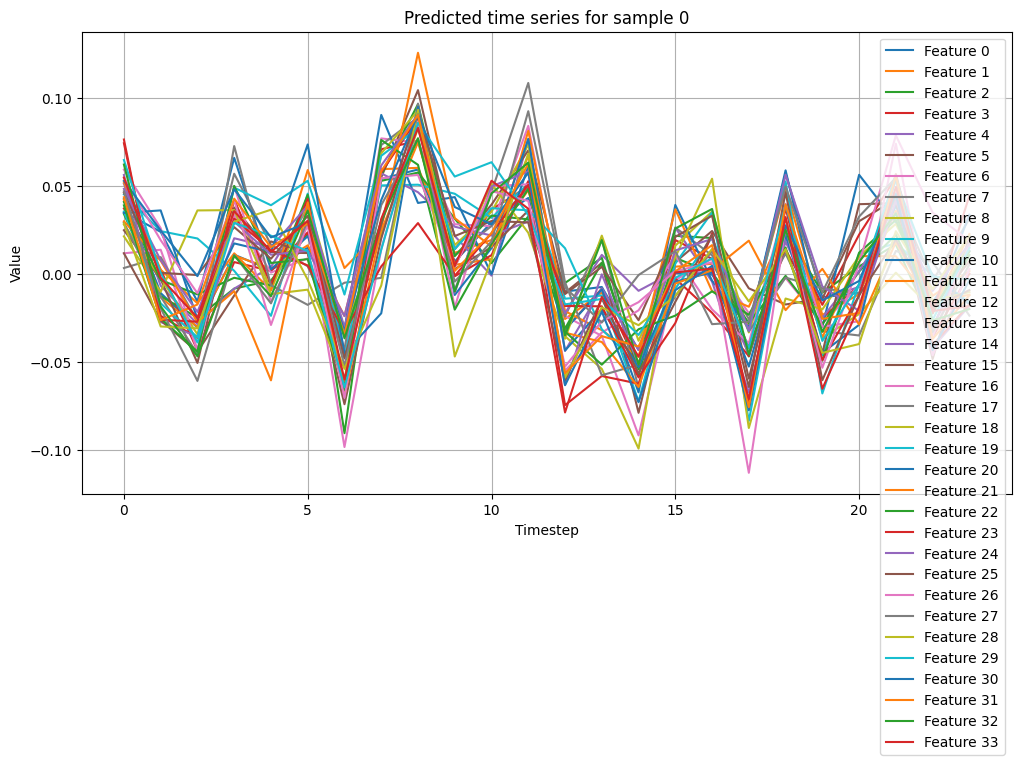

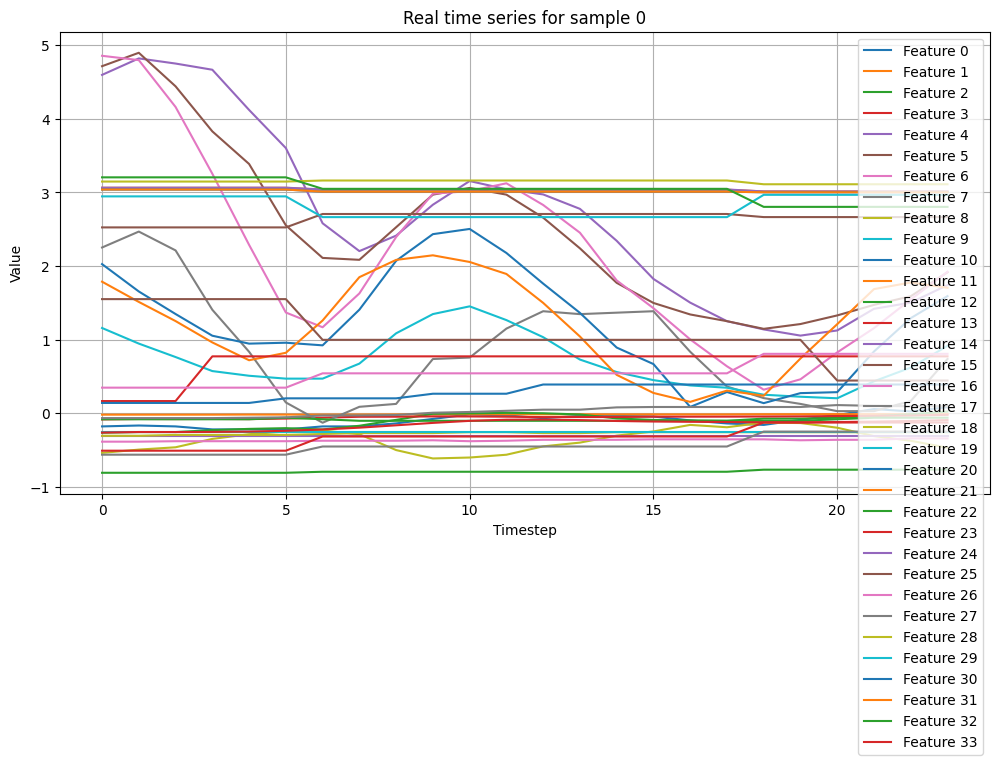

In [ ]:
# x: (B, T, D)
B, T, D = 32, 12, 34
sample_idx = 0
x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()


# Training

In [ ]:
# Data augmentation functions

def jitter(x, sigma=0.01):
    noise = torch.randn_like(x) * sigma
    return x + noise

def scaling(x, scale_std=0.1):
    scale = torch.normal(mean=1.0, std=scale_std, size=(x.shape[0], 1, x.shape[2])).to(x.device)
    return x * scale

def time_stretch(x, scale_range=(0.9, 1.1)):
    B, T, C = x.size()
    scale = torch.FloatTensor(B).uniform_(*scale_range).to(x.device)
    stretched = []
    for i in range(B):
        t_len = int(T * scale[i])
        stretched_x = F.interpolate(x[i].unsqueeze(0).permute(0, 2, 1), size=t_len, mode='linear', align_corners=False)
        if t_len > T:
            stretched_x = stretched_x[:, :, :T]  # crop
        else:
            pad_len = T - t_len
            stretched_x = F.pad(stretched_x, (0, pad_len))  # pad
        stretched.append(stretched_x.permute(0, 2, 1))
    return torch.cat(stretched, dim=0)

def masking_augment_fast(x, mask_ratio=0.15, mask_value=0.0):
    mask = torch.bernoulli(torch.full(x.shape[:2], mask_ratio)).bool().to(x.device)
    x = x.clone()
    x[mask] = mask_value
    return x

In [ ]:
# class to apply the data aumentations stochastically

class RandomOrderAugment:
    def __init__(self, augments):
        self.augments = augments  # List of (augment_fn, probability)

    def __call__(self, x):
        return x

augment = RandomOrderAugment([
    (jitter, 0.7),
    (scaling, 0.5),
    (time_stretch, 0.3),
    (masking_augment_fast, 0.9)
])

In [ ]:
B, orig_len, D = 32, 12, 34
K = 3
C = 2
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
)

In [ ]:
# training function

def train_ratd(
    model,
    train_loader,
    encoder=encoder_loaded,
    retrieval_db=retrieval_db,
    k=K,
    val_loader=None,
    orig_len=12,
    epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='best_model.pt'
):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-8
    )
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    start_epoch = 1

    # === Recover Checkpoint ===
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint found. Restart from epoch {start_epoch} with best_val_loss {best_val_loss:.6f}.")

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for x, timestamps, _ in pbar:
            # === Data Augmentation ===
            x = augment(x)
            # retrieve the top-k similar series
            xr = retrieve_knn(x[:, 0:orig_len, :], encoder, faiss_index, xr_target, k=k, device=device)
            x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)

            optimizer.zero_grad()
            loss, pred = model.calc_loss(x, timestamps, xr=xr)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            mse_loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])

            train_loss += mse_loss.item()
            pbar.set_postfix(loss=mse_loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}")

        # === VALIDATION ===
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, timestamps, _ in val_loader:
                    xr = retrieve_knn(x[:, 0:orig_len, :], encoder, faiss_index, xr_target, k=k, device=device)
                    x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)
                    _, pred = model.calc_loss_validation(x, timestamps, xr=xr)
                    loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.6f}")

            scheduler.step(avg_val_loss)

            # === Save the best model ===
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss
                }, save_path)
                print(f"Saved best model at {save_path}")


In [ ]:
train_ratd(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    lr=2.5e-4,
    save_path="models/ratd_best.pt"
)

Epoch 1 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.81it/s, loss=0.143] 


Epoch 1: Train Loss = 0.530855
Epoch 1: Val Loss = 0.251465
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 2 [Train]: 100%|██████████| 802/802 [00:44<00:00, 18.06it/s, loss=0.0739]


Epoch 2: Train Loss = 0.200172
Epoch 2: Val Loss = 0.216961
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 3 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.92it/s, loss=0.0922]


Epoch 3: Train Loss = 0.191655
Epoch 3: Val Loss = 0.210504
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 4 [Train]: 100%|██████████| 802/802 [00:44<00:00, 18.15it/s, loss=0.0907]


Epoch 4: Train Loss = 0.183223
Epoch 4: Val Loss = 0.195461
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 5 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.95it/s, loss=0.106] 


Epoch 5: Train Loss = 0.170593
Epoch 5: Val Loss = 0.183501
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 6 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.88it/s, loss=0.0757]


Epoch 6: Train Loss = 0.159919
Epoch 6: Val Loss = 0.173439
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 7 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.76it/s, loss=0.0819]


Epoch 7: Train Loss = 0.152551
Epoch 7: Val Loss = 0.166846
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 8 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.61it/s, loss=0.038] 


Epoch 8: Train Loss = 0.147351
Epoch 8: Val Loss = 0.160626
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 9 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.64it/s, loss=0.0353]


Epoch 9: Train Loss = 0.143311
Epoch 9: Val Loss = 0.157439
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 10 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.71it/s, loss=0.0695]


Epoch 10: Train Loss = 0.140835
Epoch 10: Val Loss = 0.154736
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 11 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.77it/s, loss=0.181] 


Epoch 11: Train Loss = 0.137618
Epoch 11: Val Loss = 0.151353
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 12 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.68it/s, loss=0.0417]


Epoch 12: Train Loss = 0.135496
Epoch 12: Val Loss = 0.149540
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 13 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.61it/s, loss=0.109] 


Epoch 13: Train Loss = 0.133381
Epoch 13: Val Loss = 0.149679


Epoch 14 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.74it/s, loss=0.0361]


Epoch 14: Train Loss = 0.131038
Epoch 14: Val Loss = 0.146340
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 15 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.87it/s, loss=0.0338]


Epoch 15: Train Loss = 0.127827
Epoch 15: Val Loss = 0.143887
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 16 [Train]: 100%|██████████| 802/802 [00:44<00:00, 18.09it/s, loss=0.054] 


Epoch 16: Train Loss = 0.126071
Epoch 16: Val Loss = 0.143020
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 17 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.99it/s, loss=0.0222]


Epoch 17: Train Loss = 0.123678
Epoch 17: Val Loss = 0.139959
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 18 [Train]: 100%|██████████| 802/802 [00:44<00:00, 18.10it/s, loss=0.058] 


Epoch 18: Train Loss = 0.120546
Epoch 18: Val Loss = 0.136659
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 19 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.92it/s, loss=0.118] 


Epoch 19: Train Loss = 0.115766
Epoch 19: Val Loss = 0.129307
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 20 [Train]: 100%|██████████| 802/802 [00:44<00:00, 17.85it/s, loss=0.0318]


Epoch 20: Train Loss = 0.106872
Epoch 20: Val Loss = 0.121612
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 21 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.60it/s, loss=0.159] 


Epoch 21: Train Loss = 0.097859
Epoch 21: Val Loss = 0.115526
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 22 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.82it/s, loss=0.0218]


Epoch 22: Train Loss = 0.089299
Epoch 22: Val Loss = 0.110454
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 23 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.49it/s, loss=1.67]  


Epoch 23: Train Loss = 0.082781
Epoch 23: Val Loss = 0.107411
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 24 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.67it/s, loss=0.0347]


Epoch 24: Train Loss = 0.076279
Epoch 24: Val Loss = 0.103830
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 25 [Train]: 100%|██████████| 802/802 [00:45<00:00, 17.60it/s, loss=0.0179] 


Epoch 25: Train Loss = 0.071975
Epoch 25: Val Loss = 0.102229
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 26 [Train]: 100%|██████████| 802/802 [00:44<00:00, 18.10it/s, loss=0.0127]


Epoch 26: Train Loss = 0.067583
Epoch 26: Val Loss = 0.100833
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 27 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.39it/s, loss=0.0228] 


Epoch 27: Train Loss = 0.064029
Epoch 27: Val Loss = 0.098622
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 28 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.51it/s, loss=0.0354] 


Epoch 28: Train Loss = 0.060805
Epoch 28: Val Loss = 0.097723
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 29 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.39it/s, loss=0.0233] 


Epoch 29: Train Loss = 0.058022
Epoch 29: Val Loss = 0.095841
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 30 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.47it/s, loss=0.0247] 


Epoch 30: Train Loss = 0.055460
Epoch 30: Val Loss = 0.094543
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 31 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.45it/s, loss=0.0135] 


Epoch 31: Train Loss = 0.053193
Epoch 31: Val Loss = 0.093348
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 32 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.45it/s, loss=0.0122] 


Epoch 32: Train Loss = 0.051357
Epoch 32: Val Loss = 0.092725
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 33 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.35it/s, loss=0.0476] 


Epoch 33: Train Loss = 0.049335
Epoch 33: Val Loss = 0.093081


Epoch 34 [Train]: 100%|██████████| 802/802 [00:44<00:00, 18.22it/s, loss=0.0236] 


Epoch 34: Train Loss = 0.047636
Epoch 34: Val Loss = 0.090638
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 35 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.27it/s, loss=0.0119] 


Epoch 35: Train Loss = 0.045850
Epoch 35: Val Loss = 0.090252
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 36 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.44it/s, loss=0.0143] 


Epoch 36: Train Loss = 0.044653
Epoch 36: Val Loss = 0.090021
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 37 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.38it/s, loss=0.0144] 


Epoch 37: Train Loss = 0.043449
Epoch 37: Val Loss = 0.089090
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 38 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.43it/s, loss=0.0274] 


Epoch 38: Train Loss = 0.041872
Epoch 38: Val Loss = 0.087998
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 39 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.47it/s, loss=0.0975] 


Epoch 39: Train Loss = 0.040850
Epoch 39: Val Loss = 0.088075


Epoch 40 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.36it/s, loss=0.0195] 


Epoch 40: Train Loss = 0.039770
Epoch 40: Val Loss = 0.088417


Epoch 41 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.25it/s, loss=0.0405] 


Epoch 41: Train Loss = 0.038822
Epoch 41: Val Loss = 0.086829
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 42 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.48it/s, loss=0.0147] 


Epoch 42: Train Loss = 0.037970
Epoch 42: Val Loss = 0.089600


Epoch 43 [Train]: 100%|██████████| 802/802 [00:43<00:00, 18.42it/s, loss=0.0099] 


Epoch 43: Train Loss = 0.037210
Epoch 43: Val Loss = 0.087174


Epoch 44 [Train]: 100%|██████████| 802/802 [00:42<00:00, 18.73it/s, loss=0.012]  


Epoch 44: Train Loss = 0.036183
Epoch 44: Val Loss = 0.086313
Saved best model at /kaggle/working/models/ratd_best.pt


Epoch 45 [Train]:  49%|████▉     | 392/802 [00:20<00:21, 19.24it/s, loss=0.0174] 

In [ ]:
train_ratd(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=2.5e-4,
    save_path="models/ratd_best.pt"
)

C:\Users\saver\AppData\Local\Temp\ipykernel_23664\3094464141.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Checkpoint found. Restart from epoch 45 with best_val_loss 0.086313.


Epoch 45 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.00859]


Epoch 45: Train Loss = 0.035924
Epoch 45: Val Loss = 0.088281


Epoch 46 [Train]: 100%|██████████| 802/802 [04:14<00:00,  3.15it/s, loss=0.0414] 


Epoch 46: Train Loss = 0.034756
Epoch 46: Val Loss = 0.086457


Epoch 47 [Train]: 100%|██████████| 802/802 [04:16<00:00,  3.13it/s, loss=0.0176] 


Epoch 47: Train Loss = 0.034021
Epoch 47: Val Loss = 0.084712
Saved best model at models/ratd_best_3.pt


Epoch 48 [Train]: 100%|██████████| 802/802 [04:17<00:00,  3.11it/s, loss=0.00721]


Epoch 48: Train Loss = 0.033089
Epoch 48: Val Loss = 0.087065


Epoch 49 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.0366] 


Epoch 49: Train Loss = 0.032930
Epoch 49: Val Loss = 0.085525


Epoch 50 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.16it/s, loss=0.0123] 


Epoch 50: Train Loss = 0.031721
Epoch 50: Val Loss = 0.088044


Epoch 51 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.17it/s, loss=0.00494]


Epoch 51: Train Loss = 0.030423
Epoch 51: Val Loss = 0.087737


Epoch 52 [Train]: 100%|██████████| 802/802 [04:12<00:00,  3.18it/s, loss=0.00762]


Epoch 52: Train Loss = 0.029668
Epoch 52: Val Loss = 0.087705


Epoch 53 [Train]: 100%|██████████| 802/802 [04:11<00:00,  3.19it/s, loss=0.00801]


Epoch 53: Train Loss = 0.029192
Epoch 53: Val Loss = 0.085663


Epoch 54 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.16it/s, loss=0.0149] 


Epoch 54: Train Loss = 0.028495
Epoch 54: Val Loss = 0.087663


Epoch 55 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.17it/s, loss=0.00684]


Epoch 55: Train Loss = 0.028198
Epoch 55: Val Loss = 0.087473


Epoch 56 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.16it/s, loss=0.00929]


Epoch 56: Train Loss = 0.027868
Epoch 56: Val Loss = 0.087385


Epoch 57 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.0112] 


Epoch 57: Train Loss = 0.027476
Epoch 57: Val Loss = 0.087498


Epoch 58 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.00611]


Epoch 58: Train Loss = 0.027348
Epoch 58: Val Loss = 0.087397


Epoch 59 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.00391]


Epoch 59: Train Loss = 0.027186
Epoch 59: Val Loss = 0.087429


Epoch 60 [Train]: 100%|██████████| 802/802 [04:16<00:00,  3.12it/s, loss=0.016]  


Epoch 60: Train Loss = 0.027034
Epoch 60: Val Loss = 0.087626


Epoch 61 [Train]: 100%|██████████| 802/802 [04:18<00:00,  3.10it/s, loss=0.0111] 


Epoch 61: Train Loss = 0.026949
Epoch 61: Val Loss = 0.087644


Epoch 62 [Train]: 100%|██████████| 802/802 [04:23<00:00,  3.04it/s, loss=0.00564]


Epoch 62: Train Loss = 0.026901
Epoch 62: Val Loss = 0.087490


Epoch 63 [Train]: 100%|██████████| 802/802 [04:20<00:00,  3.08it/s, loss=0.00336]


Epoch 63: Train Loss = 0.026794
Epoch 63: Val Loss = 0.087497


Epoch 64 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.0119] 


Epoch 64: Train Loss = 0.026786
Epoch 64: Val Loss = 0.087601


Epoch 65 [Train]: 100%|██████████| 802/802 [04:22<00:00,  3.05it/s, loss=0.00557]


Epoch 65: Train Loss = 0.026717
Epoch 65: Val Loss = 0.087522


Epoch 66 [Train]: 100%|██████████| 802/802 [04:23<00:00,  3.04it/s, loss=0.0131] 


Epoch 66: Train Loss = 0.026676
Epoch 66: Val Loss = 0.087516


Epoch 67 [Train]: 100%|██████████| 802/802 [04:23<00:00,  3.04it/s, loss=0.0102] 


Epoch 67: Train Loss = 0.026657
Epoch 67: Val Loss = 0.087534


Epoch 68 [Train]: 100%|██████████| 802/802 [04:37<00:00,  2.89it/s, loss=0.00752]


Epoch 68: Train Loss = 0.026660
Epoch 68: Val Loss = 0.087490


Epoch 69 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.0082] 


Epoch 69: Train Loss = 0.026624
Epoch 69: Val Loss = 0.087470


Epoch 70 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0503] 


Epoch 70: Train Loss = 0.026646
Epoch 70: Val Loss = 0.087447


Epoch 71 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.00853]


Epoch 71: Train Loss = 0.026606
Epoch 71: Val Loss = 0.087495


Epoch 72 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0143] 


Epoch 72: Train Loss = 0.026613
Epoch 72: Val Loss = 0.087477


Epoch 73 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0111] 


Epoch 73: Train Loss = 0.026586
Epoch 73: Val Loss = 0.087477


Epoch 74 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.00347]


Epoch 74: Train Loss = 0.026599
Epoch 74: Val Loss = 0.087437


Epoch 75 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0076] 


Epoch 75: Train Loss = 0.026585
Epoch 75: Val Loss = 0.087487


Epoch 76 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0139] 


Epoch 76: Train Loss = 0.026594
Epoch 76: Val Loss = 0.087485


Epoch 77 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.0558] 


Epoch 77: Train Loss = 0.026587
Epoch 77: Val Loss = 0.087481


Epoch 78 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0149] 


Epoch 78: Train Loss = 0.026579
Epoch 78: Val Loss = 0.087479


Epoch 79 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.0122] 


Epoch 79: Train Loss = 0.026577
Epoch 79: Val Loss = 0.087472


Epoch 80 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0249] 


Epoch 80: Train Loss = 0.026585
Epoch 80: Val Loss = 0.087482


Epoch 81 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.02]   


Epoch 81: Train Loss = 0.026579
Epoch 81: Val Loss = 0.087484


Epoch 82 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.00654]


Epoch 82: Train Loss = 0.026559
Epoch 82: Val Loss = 0.087470


Epoch 83 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.00564]


Epoch 83: Train Loss = 0.026561
Epoch 83: Val Loss = 0.087463


Epoch 84 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.00it/s, loss=0.00973]


Epoch 84: Train Loss = 0.026571
Epoch 84: Val Loss = 0.087472


Epoch 85 [Train]: 100%|██████████| 802/802 [04:27<00:00,  2.99it/s, loss=0.00485]


Epoch 85: Train Loss = 0.026581
Epoch 85: Val Loss = 0.087476


Epoch 86 [Train]: 100%|██████████| 802/802 [04:45<00:00,  2.81it/s, loss=0.0114] 


Epoch 86: Train Loss = 0.026568
Epoch 86: Val Loss = 0.087468


Epoch 87 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.0162] 


Epoch 87: Train Loss = 0.026566
Epoch 87: Val Loss = 0.087459


Epoch 88 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.03it/s, loss=0.00833]


Epoch 88: Train Loss = 0.026559
Epoch 88: Val Loss = 0.087480


Epoch 89 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.00609]


Epoch 89: Train Loss = 0.026576
Epoch 89: Val Loss = 0.087471


Epoch 90 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.00435]


Epoch 90: Train Loss = 0.026572
Epoch 90: Val Loss = 0.087480


Epoch 91 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.00773]


Epoch 91: Train Loss = 0.026579
Epoch 91: Val Loss = 0.087469


Epoch 92 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.0115] 


Epoch 92: Train Loss = 0.026590
Epoch 92: Val Loss = 0.087474


Epoch 93 [Train]: 100%|██████████| 802/802 [04:23<00:00,  3.04it/s, loss=0.0115] 


Epoch 93: Train Loss = 0.026572
Epoch 93: Val Loss = 0.087478


Epoch 94 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.00479]


Epoch 94: Train Loss = 0.026582
Epoch 94: Val Loss = 0.087493


Epoch 95 [Train]: 100%|██████████| 802/802 [04:27<00:00,  3.00it/s, loss=0.00681]


Epoch 95: Train Loss = 0.026570
Epoch 95: Val Loss = 0.087458


Epoch 96 [Train]: 100%|██████████| 802/802 [04:27<00:00,  2.99it/s, loss=0.00425]


Epoch 96: Train Loss = 0.026565
Epoch 96: Val Loss = 0.087470


Epoch 97 [Train]: 100%|██████████| 802/802 [04:28<00:00,  2.99it/s, loss=0.0117] 


Epoch 97: Train Loss = 0.026574
Epoch 97: Val Loss = 0.087459


Epoch 98 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0347] 


Epoch 98: Train Loss = 0.026573
Epoch 98: Val Loss = 0.087467


Epoch 99 [Train]: 100%|██████████| 802/802 [04:28<00:00,  2.99it/s, loss=0.0088] 


Epoch 99: Train Loss = 0.026575
Epoch 99: Val Loss = 0.087480


Epoch 100 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.00583]


Epoch 100: Train Loss = 0.026557
Epoch 100: Val Loss = 0.087461


# Training without reference

We trained the model without using the reference for the generation process, to see how this affect on the quality of the predictions made by the model.

In [101]:
B, orig_len, D = 32, 12, 34
K = 3
C = 2
side_dim = 48
emb_dim = 16
T = orig_len + 12

alt_model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
)

In [52]:
def train_ratd_without_reference(
    model,
    train_loader,
    encoder=encoder_loaded,
    retrieval_db=retrieval_db,
    k=K,
    val_loader=None,
    orig_len=12,
    epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='best_model.pt'
):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-8
    )
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    start_epoch = 1

    # === Recover Checkpoint ===
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint found. Restart from epoch {start_epoch} with best_val_loss {best_val_loss:.6f}.")

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for x, timestamps, _ in pbar:
            # === Data Augmentation ===
            x = augment(x)
            x, timestamps = x.to(device), timestamps.to(device)

            optimizer.zero_grad()
            loss, pred = model.calc_loss(x, timestamps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            mse_loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])

            train_loss += mse_loss.item()
            pbar.set_postfix(loss=mse_loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}")

        # === VALIDATION ===
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, timestamps, _ in val_loader:
                    x, timestamps = x.to(device), timestamps.to(device)
                    _, pred = model.calc_loss_validation(x, timestamps)
                    loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.6f}")

            scheduler.step(avg_val_loss)

            # === Save the best model ===
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss
                }, save_path)
                print(f"Saved best model at {save_path}")


In [102]:
train_ratd_without_reference(
    model=alt_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=2.5e-4,
    save_path="models/ratd_best_without_reference.pt"
)

Epoch 1 [Train]: 100%|██████████| 802/802 [03:37<00:00,  3.69it/s, loss=0.166]


Epoch 1: Train Loss = 0.389140
Epoch 1: Val Loss = 0.289093
Saved best model at models/ratd_best_without_reference.pt


Epoch 2 [Train]: 100%|██████████| 802/802 [03:34<00:00,  3.74it/s, loss=0.136] 


Epoch 2: Train Loss = 0.210529
Epoch 2: Val Loss = 0.252363
Saved best model at models/ratd_best_without_reference.pt


Epoch 3 [Train]: 100%|██████████| 802/802 [04:03<00:00,  3.29it/s, loss=0.0974]


Epoch 3: Train Loss = 0.192707
Epoch 3: Val Loss = 0.241152
Saved best model at models/ratd_best_without_reference.pt


Epoch 4 [Train]: 100%|██████████| 802/802 [03:59<00:00,  3.35it/s, loss=0.102] 


Epoch 4: Train Loss = 0.177328
Epoch 4: Val Loss = 0.213436
Saved best model at models/ratd_best_without_reference.pt


Epoch 5 [Train]: 100%|██████████| 802/802 [04:04<00:00,  3.28it/s, loss=0.127] 


Epoch 5: Train Loss = 0.168279
Epoch 5: Val Loss = 0.203908
Saved best model at models/ratd_best_without_reference.pt


Epoch 6 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.16it/s, loss=0.0561]


Epoch 6: Train Loss = 0.165437
Epoch 6: Val Loss = 0.197270
Saved best model at models/ratd_best_without_reference.pt


Epoch 7 [Train]: 100%|██████████| 802/802 [04:11<00:00,  3.19it/s, loss=0.103] 


Epoch 7: Train Loss = 0.163600
Epoch 7: Val Loss = 0.192108
Saved best model at models/ratd_best_without_reference.pt


Epoch 8 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.122] 


Epoch 8: Train Loss = 0.160250
Epoch 8: Val Loss = 0.186954
Saved best model at models/ratd_best_without_reference.pt


Epoch 9 [Train]: 100%|██████████| 802/802 [04:18<00:00,  3.11it/s, loss=0.0703]


Epoch 9: Train Loss = 0.157646
Epoch 9: Val Loss = 0.182940
Saved best model at models/ratd_best_without_reference.pt


Epoch 10 [Train]: 100%|██████████| 802/802 [04:10<00:00,  3.20it/s, loss=0.916] 


Epoch 10: Train Loss = 0.155149
Epoch 10: Val Loss = 0.180198
Saved best model at models/ratd_best_without_reference.pt


Epoch 11 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.16it/s, loss=0.0901]


Epoch 11: Train Loss = 0.152678
Epoch 11: Val Loss = 0.177037
Saved best model at models/ratd_best_without_reference.pt


Epoch 12 [Train]: 100%|██████████| 802/802 [04:20<00:00,  3.08it/s, loss=0.0985]


Epoch 12: Train Loss = 0.151184
Epoch 12: Val Loss = 0.175379
Saved best model at models/ratd_best_without_reference.pt


Epoch 13 [Train]: 100%|██████████| 802/802 [04:20<00:00,  3.08it/s, loss=0.073] 


Epoch 13: Train Loss = 0.150317
Epoch 13: Val Loss = 0.173893
Saved best model at models/ratd_best_without_reference.pt


Epoch 14 [Train]: 100%|██████████| 802/802 [04:30<00:00,  2.97it/s, loss=0.177] 


Epoch 14: Train Loss = 0.148760
Epoch 14: Val Loss = 0.172013
Saved best model at models/ratd_best_without_reference.pt


Epoch 15 [Train]: 100%|██████████| 802/802 [05:51<00:00,  2.28it/s, loss=0.186] 


Epoch 15: Train Loss = 0.147379
Epoch 15: Val Loss = 0.169886
Saved best model at models/ratd_best_without_reference.pt


Epoch 16 [Train]: 100%|██████████| 802/802 [05:10<00:00,  2.59it/s, loss=0.239] 


Epoch 16: Train Loss = 0.146176
Epoch 16: Val Loss = 0.170389


Epoch 17 [Train]: 100%|██████████| 802/802 [04:33<00:00,  2.93it/s, loss=0.0858]


Epoch 17: Train Loss = 0.144348
Epoch 17: Val Loss = 0.168815
Saved best model at models/ratd_best_without_reference.pt


Epoch 18 [Train]: 100%|██████████| 802/802 [04:24<00:00,  3.03it/s, loss=0.117] 


Epoch 18: Train Loss = 0.143511
Epoch 18: Val Loss = 0.167335
Saved best model at models/ratd_best_without_reference.pt


Epoch 19 [Train]: 100%|██████████| 802/802 [04:29<00:00,  2.98it/s, loss=0.155] 


Epoch 19: Train Loss = 0.142919
Epoch 19: Val Loss = 0.165627
Saved best model at models/ratd_best_without_reference.pt


Epoch 20 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.373] 


Epoch 20: Train Loss = 0.142497
Epoch 20: Val Loss = 0.165573
Saved best model at models/ratd_best_without_reference.pt


Epoch 21 [Train]: 100%|██████████| 802/802 [04:27<00:00,  3.00it/s, loss=0.105] 


Epoch 21: Train Loss = 0.141090
Epoch 21: Val Loss = 0.165823


Epoch 22 [Train]: 100%|██████████| 802/802 [04:18<00:00,  3.10it/s, loss=0.0725]


Epoch 22: Train Loss = 0.139863
Epoch 22: Val Loss = 0.165076
Saved best model at models/ratd_best_without_reference.pt


Epoch 23 [Train]: 100%|██████████| 802/802 [04:20<00:00,  3.08it/s, loss=0.0653]


Epoch 23: Train Loss = 0.139707
Epoch 23: Val Loss = 0.163803
Saved best model at models/ratd_best_without_reference.pt


Epoch 24 [Train]: 100%|██████████| 802/802 [04:20<00:00,  3.07it/s, loss=0.0903]


Epoch 24: Train Loss = 0.138167
Epoch 24: Val Loss = 0.163487
Saved best model at models/ratd_best_without_reference.pt


Epoch 25 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.0945]


Epoch 25: Train Loss = 0.138237
Epoch 25: Val Loss = 0.163597


Epoch 26 [Train]: 100%|██████████| 802/802 [04:21<00:00,  3.07it/s, loss=0.0703]


Epoch 26: Train Loss = 0.138212
Epoch 26: Val Loss = 0.162858
Saved best model at models/ratd_best_without_reference.pt


Epoch 27 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.0774]


Epoch 27: Train Loss = 0.136494
Epoch 27: Val Loss = 0.162614
Saved best model at models/ratd_best_without_reference.pt


Epoch 28 [Train]: 100%|██████████| 802/802 [04:25<00:00,  3.02it/s, loss=0.0985]


Epoch 28: Train Loss = 0.135753
Epoch 28: Val Loss = 0.162578
Saved best model at models/ratd_best_without_reference.pt


Epoch 29 [Train]: 100%|██████████| 802/802 [04:20<00:00,  3.07it/s, loss=0.0896]


Epoch 29: Train Loss = 0.134036
Epoch 29: Val Loss = 0.162219
Saved best model at models/ratd_best_without_reference.pt


Epoch 30 [Train]: 100%|██████████| 802/802 [04:35<00:00,  2.91it/s, loss=0.131] 


Epoch 30: Train Loss = 0.134985
Epoch 30: Val Loss = 0.160866
Saved best model at models/ratd_best_without_reference.pt


Epoch 31 [Train]: 100%|██████████| 802/802 [04:37<00:00,  2.89it/s, loss=0.0805]


Epoch 31: Train Loss = 0.134247
Epoch 31: Val Loss = 0.160780
Saved best model at models/ratd_best_without_reference.pt


Epoch 32 [Train]: 100%|██████████| 802/802 [04:41<00:00,  2.85it/s, loss=0.124] 


Epoch 32: Train Loss = 0.133416
Epoch 32: Val Loss = 0.160742
Saved best model at models/ratd_best_without_reference.pt


Epoch 33 [Train]: 100%|██████████| 802/802 [04:39<00:00,  2.87it/s, loss=0.0699]


Epoch 33: Train Loss = 0.133684
Epoch 33: Val Loss = 0.160786


Epoch 34 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.01it/s, loss=0.231] 


Epoch 34: Train Loss = 0.130832
Epoch 34: Val Loss = 0.159650
Saved best model at models/ratd_best_without_reference.pt


Epoch 35 [Train]: 100%|██████████| 802/802 [04:41<00:00,  2.85it/s, loss=0.129] 


Epoch 35: Train Loss = 0.131413
Epoch 35: Val Loss = 0.158532
Saved best model at models/ratd_best_without_reference.pt


Epoch 36 [Train]: 100%|██████████| 802/802 [04:42<00:00,  2.84it/s, loss=0.154] 


Epoch 36: Train Loss = 0.129283
Epoch 36: Val Loss = 0.158483
Saved best model at models/ratd_best_without_reference.pt


Epoch 37 [Train]: 100%|██████████| 802/802 [04:21<00:00,  3.07it/s, loss=0.13]  


Epoch 37: Train Loss = 0.130511
Epoch 37: Val Loss = 0.159549


Epoch 38 [Train]: 100%|██████████| 802/802 [04:39<00:00,  2.87it/s, loss=0.136] 


Epoch 38: Train Loss = 0.129573
Epoch 38: Val Loss = 0.157636
Saved best model at models/ratd_best_without_reference.pt


Epoch 39 [Train]: 100%|██████████| 802/802 [04:27<00:00,  2.99it/s, loss=0.0635]


Epoch 39: Train Loss = 0.127110
Epoch 39: Val Loss = 0.156602
Saved best model at models/ratd_best_without_reference.pt


Epoch 40 [Train]: 100%|██████████| 802/802 [04:21<00:00,  3.07it/s, loss=0.0799]


Epoch 40: Train Loss = 0.128415
Epoch 40: Val Loss = 0.156231
Saved best model at models/ratd_best_without_reference.pt


Epoch 41 [Train]: 100%|██████████| 802/802 [04:27<00:00,  3.00it/s, loss=0.0564]


Epoch 41: Train Loss = 0.128156
Epoch 41: Val Loss = 0.155479
Saved best model at models/ratd_best_without_reference.pt


Epoch 42 [Train]: 100%|██████████| 802/802 [04:36<00:00,  2.90it/s, loss=0.0803]


Epoch 42: Train Loss = 0.126336
Epoch 42: Val Loss = 0.155257
Saved best model at models/ratd_best_without_reference.pt


Epoch 43 [Train]: 100%|██████████| 802/802 [04:44<00:00,  2.82it/s, loss=0.0491]


Epoch 43: Train Loss = 0.124380
Epoch 43: Val Loss = 0.153334
Saved best model at models/ratd_best_without_reference.pt


Epoch 44 [Train]: 100%|██████████| 802/802 [04:32<00:00,  2.95it/s, loss=0.058] 


Epoch 44: Train Loss = 0.127197
Epoch 44: Val Loss = 0.154037


Epoch 45 [Train]: 100%|██████████| 802/802 [04:28<00:00,  2.99it/s, loss=0.0626]


Epoch 45: Train Loss = 0.123431
Epoch 45: Val Loss = 0.154963


Epoch 46 [Train]: 100%|██████████| 802/802 [04:33<00:00,  2.93it/s, loss=0.093] 


Epoch 46: Train Loss = 0.124983
Epoch 46: Val Loss = 0.153174
Saved best model at models/ratd_best_without_reference.pt


Epoch 47 [Train]: 100%|██████████| 802/802 [04:34<00:00,  2.92it/s, loss=0.0465]


Epoch 47: Train Loss = 0.124382
Epoch 47: Val Loss = 0.152665
Saved best model at models/ratd_best_without_reference.pt


Epoch 48 [Train]: 100%|██████████| 802/802 [04:37<00:00,  2.89it/s, loss=0.0632]


Epoch 48: Train Loss = 0.122739
Epoch 48: Val Loss = 0.153083


Epoch 49 [Train]: 100%|██████████| 802/802 [04:28<00:00,  2.99it/s, loss=0.0706]


Epoch 49: Train Loss = 0.122835
Epoch 49: Val Loss = 0.153289


Epoch 50 [Train]: 100%|██████████| 802/802 [04:40<00:00,  2.86it/s, loss=0.0646]


Epoch 50: Train Loss = 0.121658
Epoch 50: Val Loss = 0.151579
Saved best model at models/ratd_best_without_reference.pt


Epoch 51 [Train]: 100%|██████████| 802/802 [04:38<00:00,  2.88it/s, loss=0.0663]


Epoch 51: Train Loss = 0.121513
Epoch 51: Val Loss = 0.151844


Epoch 52 [Train]: 100%|██████████| 802/802 [04:12<00:00,  3.18it/s, loss=0.0461]


Epoch 52: Train Loss = 0.119973
Epoch 52: Val Loss = 0.152109


Epoch 53 [Train]: 100%|██████████| 802/802 [04:02<00:00,  3.31it/s, loss=0.0656]


Epoch 53: Train Loss = 0.121252
Epoch 53: Val Loss = 0.151674


Epoch 54 [Train]: 100%|██████████| 802/802 [03:57<00:00,  3.37it/s, loss=0.0743]


Epoch 54: Train Loss = 0.119291
Epoch 54: Val Loss = 0.149890
Saved best model at models/ratd_best_without_reference.pt


Epoch 55 [Train]: 100%|██████████| 802/802 [04:13<00:00,  3.16it/s, loss=0.0448]


Epoch 55: Train Loss = 0.117247
Epoch 55: Val Loss = 0.149503
Saved best model at models/ratd_best_without_reference.pt


Epoch 56 [Train]: 100%|██████████| 802/802 [03:51<00:00,  3.46it/s, loss=0.173] 


Epoch 56: Train Loss = 0.116560
Epoch 56: Val Loss = 0.149472
Saved best model at models/ratd_best_without_reference.pt


Epoch 57 [Train]: 100%|██████████| 802/802 [03:53<00:00,  3.44it/s, loss=0.0985]


Epoch 57: Train Loss = 0.114812
Epoch 57: Val Loss = 0.148999
Saved best model at models/ratd_best_without_reference.pt


Epoch 58 [Train]: 100%|██████████| 802/802 [03:53<00:00,  3.43it/s, loss=0.228] 


Epoch 58: Train Loss = 0.116099
Epoch 58: Val Loss = 0.149511


Epoch 59 [Train]: 100%|██████████| 802/802 [03:52<00:00,  3.45it/s, loss=0.0333]


Epoch 59: Train Loss = 0.113950
Epoch 59: Val Loss = 0.150203


Epoch 60 [Train]: 100%|██████████| 802/802 [03:50<00:00,  3.48it/s, loss=0.151] 


Epoch 60: Train Loss = 0.114753
Epoch 60: Val Loss = 0.149170


Epoch 61 [Train]: 100%|██████████| 802/802 [03:53<00:00,  3.44it/s, loss=0.0727]


Epoch 61: Train Loss = 0.113996
Epoch 61: Val Loss = 0.147251
Saved best model at models/ratd_best_without_reference.pt


Epoch 62 [Train]: 100%|██████████| 802/802 [03:56<00:00,  3.39it/s, loss=0.0716]


Epoch 62: Train Loss = 0.113265
Epoch 62: Val Loss = 0.146154
Saved best model at models/ratd_best_without_reference.pt


Epoch 63 [Train]: 100%|██████████| 802/802 [03:53<00:00,  3.43it/s, loss=0.0616]


Epoch 63: Train Loss = 0.111717
Epoch 63: Val Loss = 0.145907
Saved best model at models/ratd_best_without_reference.pt


Epoch 64 [Train]: 100%|██████████| 802/802 [03:51<00:00,  3.47it/s, loss=0.056] 


Epoch 64: Train Loss = 0.112805
Epoch 64: Val Loss = 0.145880
Saved best model at models/ratd_best_without_reference.pt


Epoch 65 [Train]: 100%|██████████| 802/802 [04:26<00:00,  3.00it/s, loss=0.0539]


Epoch 65: Train Loss = 0.112877
Epoch 65: Val Loss = 0.146138


Epoch 66 [Train]: 100%|██████████| 802/802 [03:59<00:00,  3.35it/s, loss=0.0343]


Epoch 66: Train Loss = 0.112151
Epoch 66: Val Loss = 0.146135


Epoch 67 [Train]: 100%|██████████| 802/802 [03:58<00:00,  3.36it/s, loss=0.0909]


Epoch 67: Train Loss = 0.114155
Epoch 67: Val Loss = 0.146198


Epoch 68 [Train]: 100%|██████████| 802/802 [03:58<00:00,  3.37it/s, loss=0.0891]


Epoch 68: Train Loss = 0.112975
Epoch 68: Val Loss = 0.145168
Saved best model at models/ratd_best_without_reference.pt


Epoch 69 [Train]: 100%|██████████| 802/802 [04:44<00:00,  2.82it/s, loss=0.0658]


Epoch 69: Train Loss = 0.113952
Epoch 69: Val Loss = 0.145069
Saved best model at models/ratd_best_without_reference.pt


Epoch 70 [Train]: 100%|██████████| 802/802 [03:53<00:00,  3.43it/s, loss=0.0546]


Epoch 70: Train Loss = 0.112852
Epoch 70: Val Loss = 0.144737
Saved best model at models/ratd_best_without_reference.pt


Epoch 71 [Train]: 100%|██████████| 802/802 [03:45<00:00,  3.55it/s, loss=0.0628]


Epoch 71: Train Loss = 0.112131
Epoch 71: Val Loss = 0.145077


Epoch 72 [Train]: 100%|██████████| 802/802 [04:18<00:00,  3.10it/s, loss=0.059] 


Epoch 72: Train Loss = 0.111103
Epoch 72: Val Loss = 0.145278


Epoch 73 [Train]: 100%|██████████| 802/802 [03:11<00:00,  4.19it/s, loss=0.0676]


Epoch 73: Train Loss = 0.109680
Epoch 73: Val Loss = 0.145069


Epoch 74 [Train]: 100%|██████████| 802/802 [03:36<00:00,  3.70it/s, loss=0.067] 


Epoch 74: Train Loss = 0.110302
Epoch 74: Val Loss = 0.144735
Saved best model at models/ratd_best_without_reference.pt


Epoch 75 [Train]: 100%|██████████| 802/802 [03:51<00:00,  3.47it/s, loss=0.0331]


Epoch 75: Train Loss = 0.110145
Epoch 75: Val Loss = 0.144623
Saved best model at models/ratd_best_without_reference.pt


Epoch 76 [Train]: 100%|██████████| 802/802 [03:50<00:00,  3.49it/s, loss=0.119] 


Epoch 76: Train Loss = 0.110969
Epoch 76: Val Loss = 0.145122


Epoch 77 [Train]: 100%|██████████| 802/802 [04:22<00:00,  3.06it/s, loss=0.0882]


Epoch 77: Train Loss = 0.109708
Epoch 77: Val Loss = 0.144872


Epoch 78 [Train]: 100%|██████████| 802/802 [04:02<00:00,  3.31it/s, loss=0.0453]


Epoch 78: Train Loss = 0.110643
Epoch 78: Val Loss = 0.143374
Saved best model at models/ratd_best_without_reference.pt


Epoch 79 [Train]: 100%|██████████| 802/802 [03:58<00:00,  3.37it/s, loss=0.0328]


Epoch 79: Train Loss = 0.110376
Epoch 79: Val Loss = 0.144109


Epoch 80 [Train]: 100%|██████████| 802/802 [03:57<00:00,  3.38it/s, loss=0.127] 


Epoch 80: Train Loss = 0.110248
Epoch 80: Val Loss = 0.143816


Epoch 81 [Train]: 100%|██████████| 802/802 [04:16<00:00,  3.13it/s, loss=3.45]  


Epoch 81: Train Loss = 0.110275
Epoch 81: Val Loss = 0.144606


Epoch 82 [Train]: 100%|██████████| 802/802 [03:53<00:00,  3.44it/s, loss=0.0943]


Epoch 82: Train Loss = 0.109511
Epoch 82: Val Loss = 0.143905


Epoch 83 [Train]: 100%|██████████| 802/802 [04:05<00:00,  3.27it/s, loss=0.0536]


Epoch 83: Train Loss = 0.109033
Epoch 83: Val Loss = 0.143901


Epoch 84 [Train]: 100%|██████████| 802/802 [04:03<00:00,  3.30it/s, loss=0.0415]


Epoch 84: Train Loss = 0.109769
Epoch 84: Val Loss = 0.144114


Epoch 85 [Train]: 100%|██████████| 802/802 [04:01<00:00,  3.31it/s, loss=0.0944]


Epoch 85: Train Loss = 0.110134
Epoch 85: Val Loss = 0.143863


Epoch 86 [Train]: 100%|██████████| 802/802 [04:07<00:00,  3.24it/s, loss=0.0455]


Epoch 86: Train Loss = 0.109283
Epoch 86: Val Loss = 0.144332


Epoch 87 [Train]: 100%|██████████| 802/802 [03:59<00:00,  3.35it/s, loss=0.047] 


Epoch 87: Train Loss = 0.109328
Epoch 87: Val Loss = 0.143798


Epoch 88 [Train]: 100%|██████████| 802/802 [04:19<00:00,  3.09it/s, loss=0.0892]


Epoch 88: Train Loss = 0.109103
Epoch 88: Val Loss = 0.143619


Epoch 89 [Train]: 100%|██████████| 802/802 [04:02<00:00,  3.30it/s, loss=0.0589]


Epoch 89: Train Loss = 0.110620
Epoch 89: Val Loss = 0.143795


Epoch 90 [Train]: 100%|██████████| 802/802 [04:05<00:00,  3.26it/s, loss=0.0545]


Epoch 90: Train Loss = 0.110536
Epoch 90: Val Loss = 0.143525


Epoch 91 [Train]: 100%|██████████| 802/802 [04:01<00:00,  3.32it/s, loss=0.174] 


Epoch 91: Train Loss = 0.110197
Epoch 91: Val Loss = 0.144120


Epoch 92 [Train]: 100%|██████████| 802/802 [04:08<00:00,  3.22it/s, loss=0.156] 


Epoch 92: Train Loss = 0.111424
Epoch 92: Val Loss = 0.143863


Epoch 93 [Train]: 100%|██████████| 802/802 [04:28<00:00,  2.99it/s, loss=0.137] 


Epoch 93: Train Loss = 0.110131
Epoch 93: Val Loss = 0.143997


Epoch 94 [Train]: 100%|██████████| 802/802 [04:16<00:00,  3.13it/s, loss=0.72]  


Epoch 94: Train Loss = 0.110903
Epoch 94: Val Loss = 0.144394


Epoch 95 [Train]: 100%|██████████| 802/802 [04:12<00:00,  3.18it/s, loss=0.0754]


Epoch 95: Train Loss = 0.111821
Epoch 95: Val Loss = 0.144036


Epoch 96 [Train]: 100%|██████████| 802/802 [04:01<00:00,  3.32it/s, loss=0.0497]


Epoch 96: Train Loss = 0.110623
Epoch 96: Val Loss = 0.143869


Epoch 97 [Train]: 100%|██████████| 802/802 [04:07<00:00,  3.24it/s, loss=0.186] 


Epoch 97: Train Loss = 0.108907
Epoch 97: Val Loss = 0.144083


Epoch 98 [Train]: 100%|██████████| 802/802 [04:10<00:00,  3.20it/s, loss=0.0469]


Epoch 98: Train Loss = 0.109066
Epoch 98: Val Loss = 0.143642


Epoch 99 [Train]: 100%|██████████| 802/802 [04:03<00:00,  3.30it/s, loss=0.057] 


Epoch 99: Train Loss = 0.109566
Epoch 99: Val Loss = 0.143978


Epoch 100 [Train]: 100%|██████████| 802/802 [04:02<00:00,  3.30it/s, loss=0.0889]


Epoch 100: Train Loss = 0.109072
Epoch 100: Val Loss = 0.143131
Saved best model at models/ratd_best_without_reference.pt


<img src="ref_eff_on_model_training.png">

# Results

In [128]:
B, orig_len, D = 32, 12, 34
K = 3
C = 2
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
)

alt_model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
)

In [129]:
checkpoint = torch.load("models/ratd_best.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

checkpoint = torch.load("models/ratd_best_without_reference.pt", map_location=device)
alt_model.load_state_dict(checkpoint['model_state_dict'])
alt_model.eval()

C:\Users\saver\AppData\Local\Temp\ipykernel_23488\2896609942.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/ratd_best.pt", map_location=

RATD(
  (ldte): LearnableDiffusionTimestepEmbedding(
    (embedding): Embedding(20, 16)
  )
  (side_module): SideInformation()
  (layers): ModuleList(
    (0-2): 3 x RATDLayer(
      (rma): RMA(
        (q_proj): Linear(in_features=34, out_features=16, bias=True)
        (k_proj): Linear(in_features=68, out_features=16, bias=True)
        (v_proj): Linear(in_features=102, out_features=16, bias=True)
        (out): Linear(in_features=16, out_features=34, bias=True)
      )
      (time_feature_conv): CausalConv1d(
        (conv): Conv1d(1152, 48, kernel_size=(3,), stride=(1,))
      )
      (diff_timestep_emb_conv): CausalConv1d(
        (conv): Conv1d(16, 48, kernel_size=(3,), stride=(1,))
      )
      (ln): LayerNorm((2, 24, 34), eps=1e-05, elementwise_affine=True)
      (temporal_transformer): TemporalTransformer(
        (transformer): LinearAttentionTransformer(
          (layers): SequentialSequence(
            (layers): ModuleList(
              (0): ModuleList(
                

In [131]:
for xb, timestamps, _ in test_loader:
    break
xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
xb, xr, timestamps= xb.to(device), xr.to(device), timestamps.to(device)
x_in = xb.detach().clone()
x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
output = model(x_in, timestamps, xr)
alt_output = alt_model(x_in, timestamps)

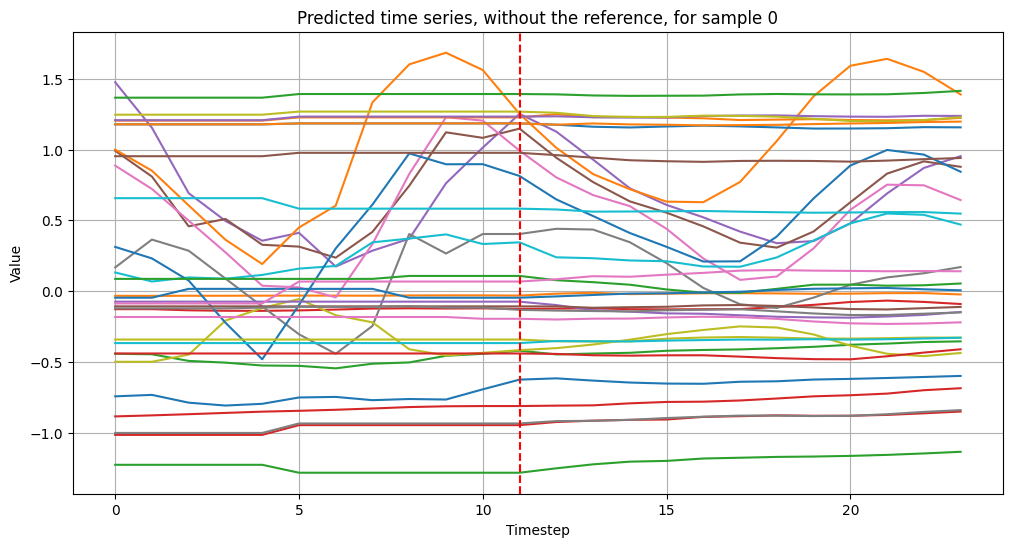

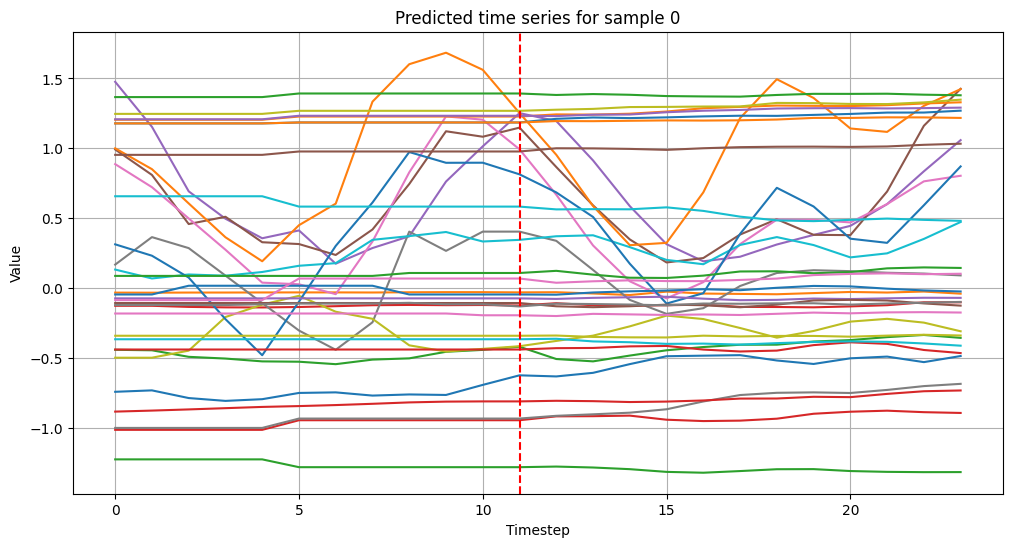

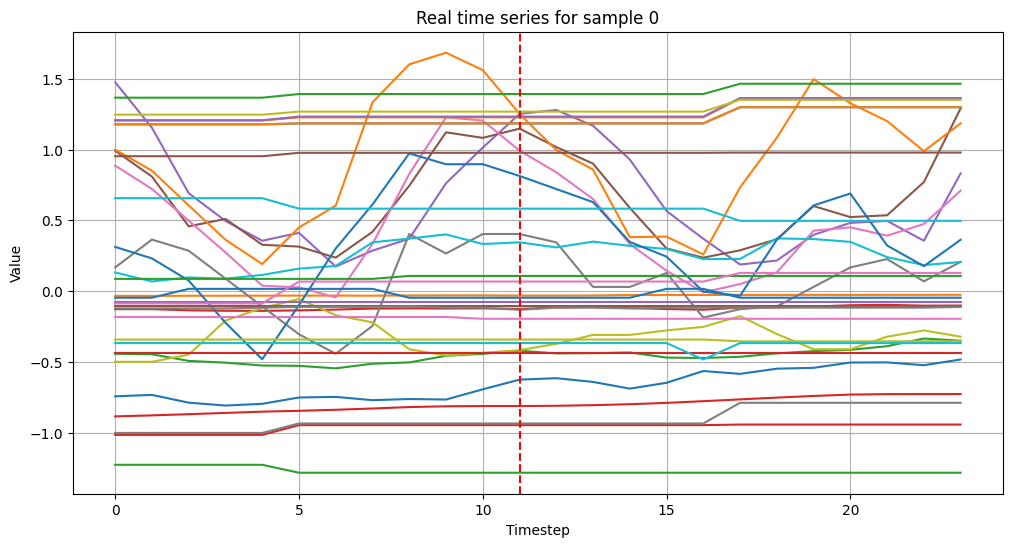

In [133]:
# x: (B, T, D)
B, T, D = 32, 14, 34
# for sample_idx in range(B):
sample_idx = 0

x_sample = alt_output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series, without the reference, for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

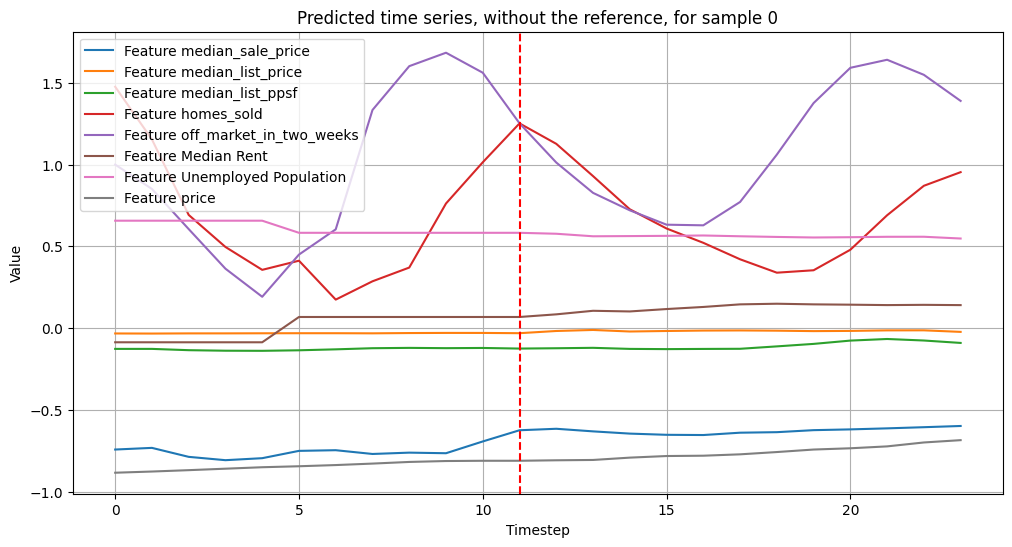

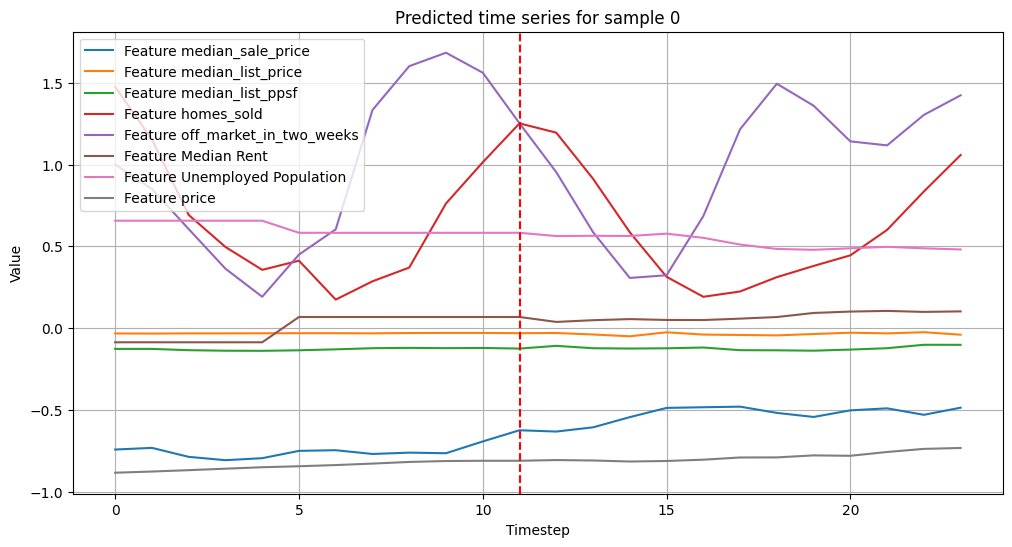

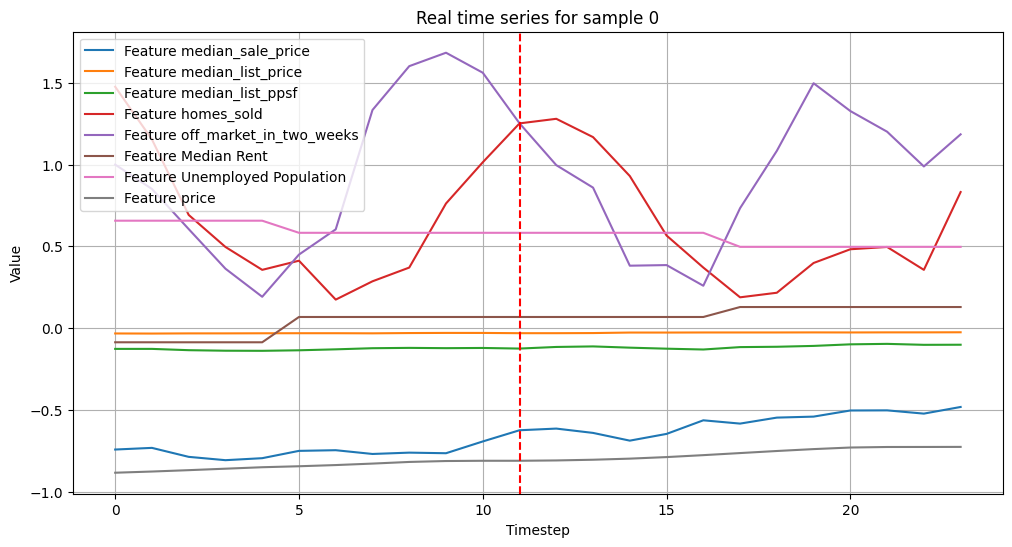

In [138]:
# x: (B, T, D)
B, T, D = 32, 14, 34
# for sample_idx in range(B):
sample_idx = 0

relevant_features_indeces = [0, 1, 3, 4, 11, 26, 29, 33]

x_sample = alt_output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series, without the reference, for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

The visual and statistical (0.084 vs 0.143 of MSE) results acknowledge the improvement brought by the guidance of a reference during the generation process.

In [ ]:
criterion = nn.MSELoss()
test_loss_per_feature = torch.zeros(34)
test_loss = 0

with torch.no_grad():
    for xb, timestamps, _ in test_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device)
        x_in = xb.detach().clone()
        x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
        output = model(x_in, timestamps, xr)

        batch_loss = 0
        for i in range(34):
            loss = criterion(output[:, orig_len:, i], xb[:, orig_len:, i])
            loss_value = loss.item()
            test_loss_per_feature[i] += loss_value
            batch_loss += loss_value
        
        test_loss += batch_loss / 34  # Average per feature, per batch

avg_test_loss = test_loss / len(test_loader)
test_loss_per_feature = test_loss_per_feature / len(test_loader)

In [141]:
print(f"Test MSE = {avg_test_loss:.6f}")

Test MSE = 0.082148


In [ ]:
criterion = nn.MSELoss()
val_loss_per_feature = torch.zeros(34)
val_loss = 0

with torch.no_grad():
    for xb, timestamps, _ in val_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device)
        x_in = xb.detach().clone()
        x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
        output = model(x_in, timestamps, xr)

        batch_loss = 0
        for i in range(34):
            loss = criterion(output[:, orig_len:, i], xb[:, orig_len:, i])
            loss_value = loss.item()
            val_loss_per_feature[i] += loss_value
            batch_loss += loss_value
        
        val_loss += batch_loss / 34  # Average per feature, per batch

avg_val_loss = val_loss / len(val_loader)
val_loss_per_feature = val_loss_per_feature / len(val_loader)

In [143]:
print(f"Val MSE = {avg_val_loss:.6f}")

Val MSE = 0.084714


In [87]:
mean_values = mean[0][0].tolist()
std_values = std[0][0].tolist()
test_mse_values = test_loss_per_feature.tolist()
val_mse_values = val_loss_per_feature.tolist()

# Create a DataFrame
data = []
for i in range(len(feature_index_mapping)):
    row = {
        'Feature': feature_index_mapping[i],
        'Mean': round(mean_values[i], 4),
        'Std': round(std_values[i], 4),
        'Test MSE': round(test_mse_values[i], 4),
        'Val MSE': round(val_mse_values[i], 4)
    }
    data.append(row)

df = pd.DataFrame(data, columns=["Feature", "Mean", "Std", "Test MSE", "Val MSE"])

df = df.sort_values(by=["Test MSE", "Val MSE"], ascending=[False, False]).reset_index(drop=True)

# Visualize
styled = df.style.set_caption("Feature-Level Summary Statistics") \
                 .format("{:.4f}", subset=["Mean", "Std", "Test MSE", "Val MSE"]) \
                 .background_gradient(subset=["Test MSE", "Val MSE"], cmap="Reds") \
                 .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])

display(styled)

,Feature,Mean,Std,Test MSE,Val MSE
0,median_list_price,559273.7070,8929021.6001,0.8665,0.7348
1,avg_sale_to_list,0.9884,0.0317,0.3812,0.3803
2,median_dom,54.4115,78.9979,0.3196,0.3506
3,sold_above_list,0.2714,0.1921,0.3133,0.2968
4,off_market_in_two_weeks,0.3191,0.2467,0.2009,0.2054
5,median_sale_price,453616.9734,245820.7292,0.1872,0.1721
6,median_list_ppsf,244.4712,561.0436,0.1773,0.3827
7,median_ppsf,227.0334,115.0888,0.0606,0.0726
8,new_listings,81.7360,84.8837,0.0527,0.0492
9,inventory,50.4805,50.8368,0.0380,0.0374


In [93]:
csv_file = "HouseTS_with_images.csv"

thresholds = [5.6e6, 5e7, 9e8] # mean for median_list_price

for threshold in thresholds:
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Ensure the column exists
    if 'median_list_price' not in df.columns:
        raise ValueError("The column 'median_list_price' was not found in the CSV file.")

    # Count how many rows have median_list_price > threshold
    count_high_price = (df['median_list_price'] > threshold).sum()

    print(f"Number of rows with 'median_list_price' > {threshold}: {count_high_price}")


Number of rows with 'median_list_price' > 5600000.0: 18
Number of rows with 'median_list_price' > 50000000.0: 6
Number of rows with 'median_list_price' > 900000000.0: 3


The performance was measured using the Mean Squared Error (MSE) metric. On the validation set, the model achieved a MSE of 0.084, while on the test set it achieved a slightly lower MSE of 0.082, indicating good generalization capabilities. A more detailed analysis revealed that, among all features, only one, the median_list_price, exhibited a significantly higher error, with a MSE of approximately 0.86 on the test set. Notably, this particular feature also had a standard deviation more than ten times larger than its onw mean, there were some outliers that made difficult to generalize on this feature, while other features presented a standard deviation close to or lower than the mean.
Overall, the results indicate robust performance across most features, with the exception of the outlier feature influenced by its inherent statistical characteristics.

# Final Considerations

The results obtained in our experiments are promising and show comparable performance to those reported in the reference paper. Specifically, despite working with a similar number of features, our model achieved prediction errors in a similar range, indicating that our architecture and preprocessing pipeline were effective. While we attempted to replicate the experimental conditions as closely as possible, including the use of publicly available platforms such as Kaggle for training, it is important to note that we did not have access to the same computational resources as the original study. This limitation may have affected training duration, batch size, and model complexity. Nevertheless, the similarity in the results suggests that our implementation closely resembles the original approach, both in design and in effectiveness, reinforcing the validity of our experimental setup.